In [ ]:
#importing all relevant packages for the project, data visualization tools, and ML algorithms
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import datetime as dt
from datetime import timedelta
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score,silhouette_samples
from sklearn.linear_model import LinearRegression,Ridge,Lasso,LogisticRegression
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error,r2_score
import statsmodels.api as sm
from statsmodels.tsa.api import Holt,SimpleExpSmoothing,ExponentialSmoothing
from fbprophet import Prophet
from sklearn.preprocessing import PolynomialFeatures
std=StandardScaler()

In [ ]:
#uploading data file, using novel data providing approximately four months of insight
from google.colab import files
uploaded = files.upload()
covid = pd.read_csv('whocovid.csv')
covid.head(20)

NameError: ignored

In [ ]:
#trying to get an idea of the amount of data and entries
covid.shape
print(covid.shape)
#converting observationdata data type for convenience
covid["Date_reported"]=pd.to_datetime(covid["Date_reported"])

(156183, 8)


In [ ]:
#see the kind of data we're dea
covid.dtypes

Date_reported        datetime64[ns]
Country_code                 object
Country                      object
WHO_region                   object
New_cases                     int64
Cumulative_cases              int64
New_deaths                    int64
Cumulative_deaths             int64
dtype: object

In [ ]:
#organizing and grouping data given in file, the most important columns being the confirmed, recovered, and death cases
datewise=covid.groupby(["Date_reported"]).agg({"Cumulative_cases":'sum',"Cumulative_deaths":'sum'})
datewise["Days Since"]=datewise.index-datewise.index.min()

In [ ]:
#displaying some key statistics giving an "big picture" idea of the situation around the world
print("Background info")
print("# of confirmed cases in the world: ",datewise["Cumulative_cases"].iloc[-1])
#print("# of recovered cases in the world: ",datewise["Recovered"].iloc[-1])
print("# of deaths in the world: ",datewise["Cumulative_deaths"].iloc[-1])

Background info
# of confirmed cases in the world:  242348657
# of deaths in the world:  4927723


In [ ]:
#organizing data by country and grouping to allow for data visualization and K-means clustering application
countrywise=covid[covid["Date_reported"]==covid["Date_reported"].max()].groupby(["Country"]).agg({"Cumulative_cases":'sum',"Cumulative_deaths":'sum'}).sort_values(["Cumulative_cases"],ascending=False)

Text(0.5, 1.0, 'Top 10 countries, Death from COVID-19')

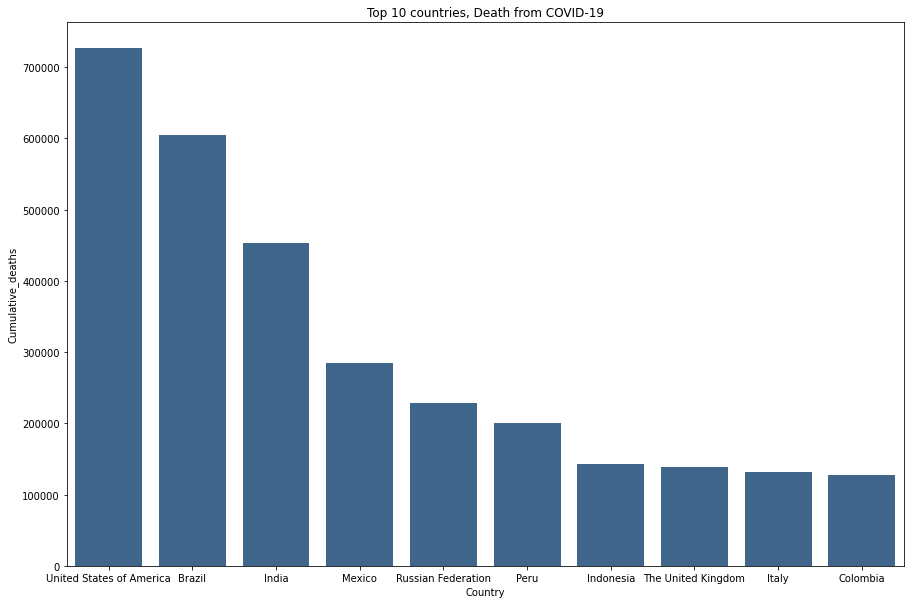

In [ ]:
#making plots showing where COVID-19 has led to the most fatalities
fig, (ax2) = plt.subplots(1,figsize=(15,10))
top_15_deaths=countrywise.sort_values(["Cumulative_deaths"],ascending=False).head(10)
#sns.barplot(x=top_15_deaths.index,y=top_15_deaths["Deaths"],ax=ax2)
sns.barplot(x=top_15_deaths.index,y=top_15_deaths["Cumulative_deaths"],ax=ax2,color=(0.2, 0.4, 0.6, 0.6))
ax2.set_title("Top 10 countries, Death from COVID-19")

In [ ]:
#applying k-means clustering to analyze how dire the situation is for countries around the world.
X=countrywise[["Cumulative_cases","Cumulative_deaths"]]
X=std.fit_transform(X)

In [ ]:
#creating a k-means method
wcss=[]
for i in range(2,8):
    clf=KMeans(n_clusters=i,init='k-means++',random_state=100)
    clf.fit(X)
    labels=clf.labels_
    centroids=clf.cluster_centers_
    wcss.append(clf.inertia_)

Text(0.5, 1.0, 'Elbow Method')

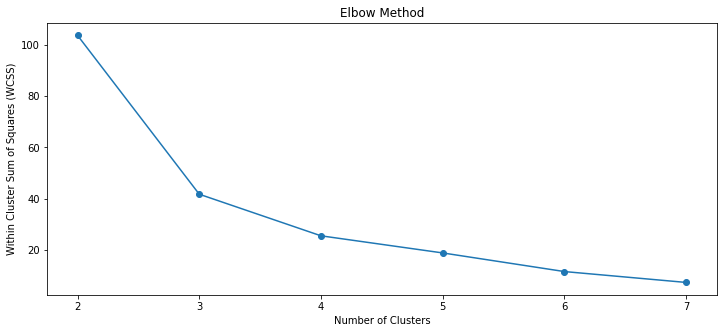

In [ ]:
#displaying results and figuring out ideal paremeters for k-means clustering
fig, (ax1) = plt.subplots(1,figsize=(12,5))
x=np.arange(2,8)
ax1.plot(x,wcss,marker='o')
ax1.set_xlabel("Number of Clusters")
ax1.set_ylabel("Within Cluster Sum of Squares (WCSS)")
ax1.set_title("Elbow Method")

In [ ]:
#i chose to have 4 clusters
clf_final=KMeans(n_clusters=4,init='k-means++',random_state=100)
clf_final.fit(X)

KMeans(n_clusters=4, random_state=100)

In [ ]:
countrywise["Clusters"]=clf_final.predict(X)

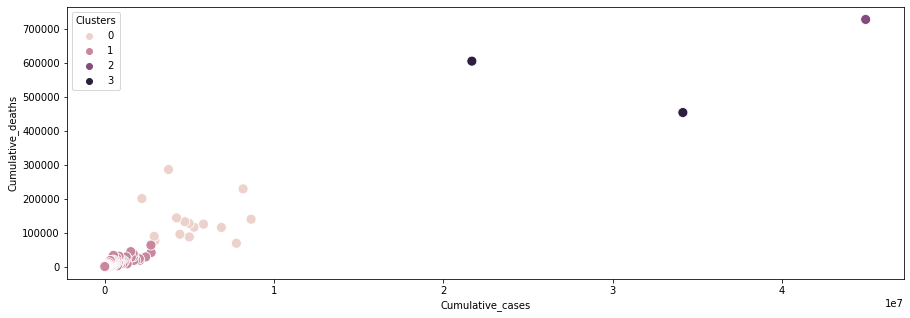

In [ ]:
#plotting the clusters
plt.figure(figsize=(15,5))
sns.scatterplot(x=countrywise["Cumulative_cases"],y=countrywise["Cumulative_deaths"],hue=countrywise["Clusters"],s=100)

In [ ]:
#Cluster 1 represents countries that have hit the worst with COVID-19
#Cluster 2 represents countries that have been moderately with COVID-19
#Cluster 3 represents countries that haven't been affected (to a certain extent) by COVID-19
pd.concat([countrywise[countrywise["Clusters"]==0],countrywise[countrywise["Clusters"]==1],countrywise[countrywise["Clusters"]==2],countrywise[countrywise["Clusters"]==3].head(25)])

,Cumulative_cases,Cumulative_deaths,Clusters
Country,,,
The United Kingdom,8641225,139146,0
Russian Federation,8168305,228453,0
Turkey,7772604,68472,0
France,6886851,115036,0
Iran (Islamic Republic of),5833525,124763,0
...,...,...,...
Nauru,0,0,1
Saint Helena,0,0,1
United States of America,44940696,726846,2


In [ ]:
#creating and applying machine learning models for prediction of confirmed cases
datewise["Days Since"]=datewise.index-datewise.index[0]
datewise["Days Since"]=datewise["Days Since"].dt.days

In [ ]:
#splitting data
train_ml=datewise.iloc[:int(datewise.shape[0]*0.95)]
valid_ml=datewise.iloc[int(datewise.shape[0]*0.95):]
model_scores=[]

In [ ]:
#Model 1: Linear Regression
lin_reg=LinearRegression(normalize=True)

In [ ]:
#model fitting
lin_reg.fit(np.array(train_ml["Days Since"]).reshape(-1,1),np.array(train_ml["Cumulative_cases"]).reshape(-1,1))

LinearRegression(normalize=True)

In [ ]:
prediction_valid_linreg=lin_reg.predict(np.array(valid_ml["Days Since"]).reshape(-1,1))

In [ ]:
#Root mean square error used for calculating how accurate a model is
model_scores.append(np.sqrt(mean_squared_error(valid_ml["Cumulative_cases"],prediction_valid_linreg)))
print("RMSE: ",np.sqrt(mean_squared_error(valid_ml["Cumulative_cases"],prediction_valid_linreg)/156000))

RMSE:  72409.6865787034


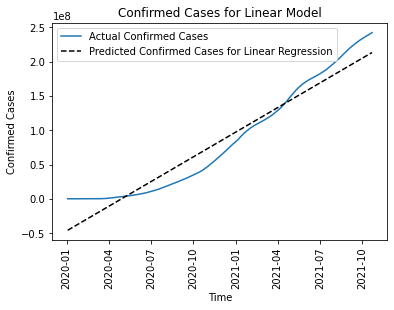

In [ ]:
#As one can see, linear regression model isn't very accurate
prediction_linreg=lin_reg.predict(np.array(datewise["Days Since"]).reshape(-1,1))
plt.plot(datewise["Cumulative_cases"],label="Actual Confirmed Cases")
plt.plot(datewise.index,prediction_linreg, linestyle='--',label="Predicted Confirmed Cases for Linear Regression",color='black')
plt.xlabel('Time')
plt.ylabel('Confirmed Cases')
plt.title("Confirmed Cases for Linear Model")
plt.xticks(rotation=90)
plt.legend()

In [ ]:
#splitting data
train_ml=datewise.iloc[:int(datewise.shape[0]*0.95)]
valid_ml=datewise.iloc[int(datewise.shape[0]*0.95):]

In [ ]:
#Polynomial Regression model
poly = PolynomialFeatures(degree = 5)

In [ ]:
#reshaping data for model
train_poly=poly.fit_transform(np.array(train_ml["Days Since"]).reshape(-1,1))
valid_poly=poly.fit_transform(np.array(valid_ml["Days Since"]).reshape(-1,1))
y=train_ml["Cumulative_cases"]

In [ ]:
#fitting model for intended purposes
linreg=LinearRegression(normalize=True)
linreg.fit(train_poly,y)

LinearRegression(normalize=True)

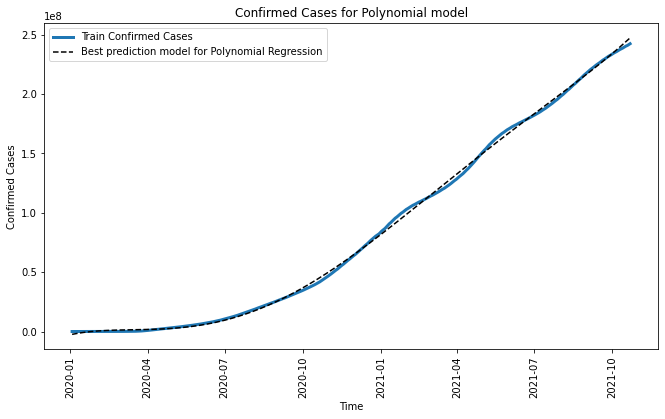

In [ ]:
comp_data=poly.fit_transform(np.array(datewise["Days Since"]).reshape(-1,1))
plt.figure(figsize=(11,6))
predictions_poly=linreg.predict(comp_data)
plt.plot(datewise["Cumulative_cases"],label="Train Confirmed Cases",linewidth=3)
plt.plot(datewise.index,predictions_poly, linestyle='--',label="Best prediction model for Polynomial Regression",color='black')
plt.xlabel('Time')
plt.ylabel('Confirmed Cases')
plt.title("Confirmed Cases for Polynomial model")
plt.xticks(rotation=90)
plt.legend()

In [ ]:
#producing predictions and error for model, as one can see
#this model is significantly more accurate the linear regression model
prediction_poly=linreg.predict(valid_poly)
rmse_poly=np.sqrt(mean_squared_error(valid_ml["Cumulative_cases"],prediction_poly))
print("Root Mean Squared Error for Polynomial Regression: ",rmse_poly)

Root Mean Squared Error for Polynomial Regression:  2427535.75823343


In [ ]:
#splitting data
train_ml=datewise.iloc[:int(datewise.shape[0]*0.95)]
valid_ml=datewise.iloc[int(datewise.shape[0]*0.95):]

In [ ]:
#Polynomial Regression model
log_reg = LogisticRegression("none")

In [ ]:
#reshaping data for model
#train_poly=log_reg.fit(np.array(train_ml["Days Since"]).reshape(-1,1))
#valid_poly=log_reg.fit(np.array(valid_ml["Days Since"]).reshape(-1,1))
log_reg.fit(np.array(train_ml["Days Since"]).reshape(-1,1),np.array(train_ml["Cumulative_cases"]).reshape(-1,1))


LogisticRegression(penalty='none')

In [ ]:
prediction_valid_logreg=log_reg.predict(np.array(valid_ml["Days Since"]).reshape(-1,1))

In [ ]:
model_scores.append(np.sqrt(mean_squared_error(valid_ml["Cumulative_cases"],prediction_valid_logreg)))
print("RMSE: ",np.sqrt(mean_squared_error(valid_ml["Cumulative_cases"],prediction_valid_logreg)))

RMSE:  14255606.81447564


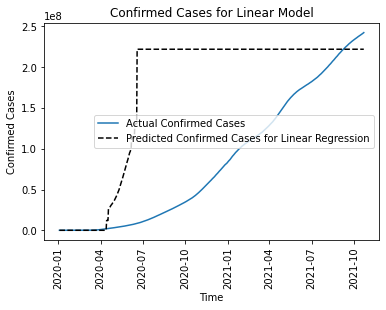

In [ ]:
#As one can see, linear regression model isn't very accurate
prediction_logreg=log_reg.predict(np.array(datewise["Days Since"]).reshape(-1,1))
plt.plot(datewise["Cumulative_cases"],label="Actual Confirmed Cases")
plt.plot(datewise.index,prediction_logreg, linestyle='--',label="Predicted Confirmed Cases for Linear Regression",color='black')
plt.xlabel('Time')
plt.ylabel('Confirmed Cases')
plt.title("Confirmed Cases for Linear Model")
plt.xticks(rotation=90)
plt.legend()